# EFFICIENTNETB0

In [3]:
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


## UPLOAD AND SPLIT DATA

In [12]:
import os
import shutil
import random
import zipfile

# ==========
# Giải nén data.zip trong Colab
# ==========
ZIP_PATH = "/content/data.zip"
EXTRACT_DIR = "/content/data"     # sau khi unzip xong -> /content/data/class_name
DEST_DIR = "/content/dataset"     # nơi chứa train/val/test

# Tỷ lệ chia
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Danh sách class
CLASSES = ["glass", "metal", "organic", "paper", "plastic", "trash"]

# -----------------------------
# Giải nén ZIP
# -----------------------------
def unzip_data():
    if not os.path.exists(EXTRACT_DIR):
        print("Unzipping data.zip ...")
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall("/content")
        print("Done unzip!")
    else:
        print("Folder already extracted.")

# -----------------------------
# Tạo thư mục dataset/train/val/test
# -----------------------------
def make_dirs():
    for split in ["train", "val", "test"]:
        for cls in CLASSES:
            os.makedirs(os.path.join(DEST_DIR, split, cls), exist_ok=True)

# -----------------------------
# Chia dữ liệu
# -----------------------------
def split_data():
    unzip_data()
    make_dirs()

    for cls in CLASSES:
        src_cls_dir = os.path.join(EXTRACT_DIR, cls)
        images = [f for f in os.listdir(src_cls_dir)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        random.shuffle(images)
        n_total = len(images)

        n_train = int(n_total * TRAIN_RATIO)
        n_val = int(n_total * VAL_RATIO)
        n_test = n_total - n_train - n_val

        train_imgs = images[:n_train]
        val_imgs = images[n_train:n_train+n_val]
        test_imgs = images[n_train+n_val:]

        # Copy ảnh
        for img in train_imgs:
            shutil.copy(os.path.join(src_cls_dir, img),
                        os.path.join(DEST_DIR, "train", cls, img))

        for img in val_imgs:
            shutil.copy(os.path.join(src_cls_dir, img),
                        os.path.join(DEST_DIR, "val", cls, img))

        for img in test_imgs:
            shutil.copy(os.path.join(src_cls_dir, img),
                        os.path.join(DEST_DIR, "test", cls, img))

        print(f"[{cls}] Total: {n_total}, Train: {len(train_imgs)}, "
              f"Val: {len(val_imgs)}, Test: {len(test_imgs)}")

    print("Done! Dataset split completely.")

# -----------------------------
if __name__ == "__main__":
    split_data()


Folder already extracted.
[glass] Total: 536, Train: 375, Val: 80, Test: 81
[metal] Total: 622, Train: 435, Val: 93, Test: 94
[organic] Total: 761, Train: 532, Val: 114, Test: 115
[paper] Total: 647, Train: 452, Val: 97, Test: 98
[plastic] Total: 601, Train: 420, Val: 90, Test: 91
[trash] Total: 606, Train: 424, Val: 90, Test: 92
Done! Dataset split completely.


## PREPROCESS

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


In [6]:
IMG_SIZE = 224
BATCH_SIZE = 16      # Quan trọng với EfficientNet
EPOCHS_HEAD = 5
EPOCHS_FINE = 20
NUM_CLASSES = 6

DATASET_DIR = "dataset"


In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [8]:
train_gen = train_datagen.flow_from_directory(
    DATASET_DIR + "/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    DATASET_DIR + "/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 2638 images belonging to 6 classes.
Found 564 images belonging to 6 classes.


## TRAIN DATA

In [9]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False   # CHỈ TRAIN HEAD TRƯỚC
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint(
        filepath="best_efficientnetb0.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        patience=3,
        factor=0.2
    )
]


In [ ]:
print("===== TRAIN HEAD =====")
history_head = model.fit(
    train_gen,
    epochs=EPOCHS_HEAD,
    validation_data=val_gen,
    callbacks=callbacks
)


===== TRAIN HEAD =====


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2660 - loss: 1.7941
Epoch 1: val_loss improved from inf to 1.25237, saving model to best_efficientnetb0.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 475s 2s/step - accuracy: 0.2664 - loss: 1.7934 - val_accuracy: 0.6425 - val_loss: 1.2524 - learning_rate: 1.0000e-04
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5895 - loss: 1.2353
Epoch 2: val_loss improved from 1.25237 to 0.94940, saving model to best_efficientnetb0.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.5896 - loss: 1.2350 - val_accuracy: 0.7573 - val_loss: 0.9494 - learning_rate: 1.0000e-04
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6952 - loss: 0.9718
Epoch 3: val_loss improved from 0.94940 to 0.78912, saving model to best_efficientnetb0.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.6953 - loss: 0.9716 - val_accuracy: 0.7922 - val_loss: 0.7891 - learning_rate: 1.0000e-04
Epoch 4/5
235/235 ━━━━━━━━━━━━━━

In [13]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
print("===== FINE-TUNING =====")
history_fine = model.fit(
    train_gen,
    epochs=EPOCHS_FINE,
    validation_data=val_gen,
    callbacks=callbacks
)


===== FINE-TUNING =====
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7138 - loss: 0.9616
Epoch 1: val_loss did not improve from 0.62679
235/235 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - accuracy: 0.7138 - loss: 0.9614 - val_accuracy: 0.8283 - val_loss: 0.6831 - learning_rate: 1.0000e-05
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7480 - loss: 0.8492
Epoch 2: val_loss did not improve from 0.62679
235/235 ━━━━━━━━━━━━━━━━━━━━ 476s 2s/step - accuracy: 0.7481 - loss: 0.8491 - val_accuracy: 0.8384 - val_loss: 0.6330 - learning_rate: 1.0000e-05
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7724 - loss: 0.7510
Epoch 3: val_loss improved from 0.62679 to 0.57083, saving model to best_efficientnetb0.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 475s 2s/step - accuracy: 0.7724 - loss: 0.7510 - val_accuracy: 0.8468 - val_loss: 0.5708 - learning_rate: 1.0000e-05
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7791 - loss: 0.6867
Epoch 4: v

## ANALYSIS

Found 1061 images belonging to 6 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 71s 970ms/step - accuracy: 0.9230 - loss: 0.2192
Test Loss: 0.2375
Test Accuracy: 0.9284
67/67 ━━━━━━━━━━━━━━━━━━━━ 68s 959ms/step


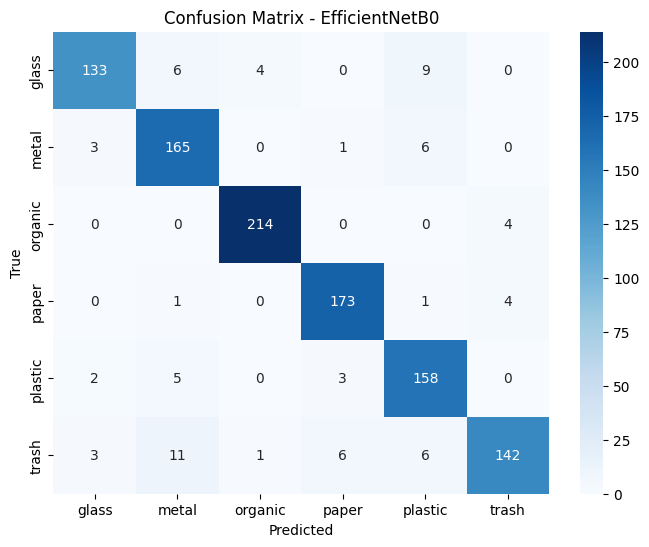

Classification Report:
              precision    recall  f1-score   support

       glass       0.94      0.88      0.91       152
       metal       0.88      0.94      0.91       175
     organic       0.98      0.98      0.98       218
       paper       0.95      0.97      0.96       179
     plastic       0.88      0.94      0.91       168
       trash       0.95      0.84      0.89       169

    accuracy                           0.93      1061
   macro avg       0.93      0.92      0.93      1061
weighted avg       0.93      0.93      0.93      1061



In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = 224
BATCH_SIZE = 16
DATASET_DIR = "/content/dataset"


test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_gen = test_datagen.flow_from_directory(
    DATASET_DIR + "/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False   # RẤT QUAN TRỌNG cho confusion matrix
)

import tensorflow as tf

model = tf.keras.models.load_model("best_efficientnetb0.keras")
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Dự đoán
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Nhãn thật
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - EfficientNetB0")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

